<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/1__pose_detection_model_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection using MoveNet

In [ ]:
# Pose Detection using MoveNet
!pip install -q tensorflow tensorflow_hub opencv-python

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from matplotlib import pyplot as plt
import requests
from PIL import Image
import io

In [ ]:
# Load MoveNet model
model_name = "movenet_singlepose_lightning"
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = module.signatures['serving_default']

In [ ]:
# Keypoint names and connections for visualization
KEYPOINT_DICT = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
    'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
    'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c', (0, 5): 'm',
    (0, 6): 'c', (5, 7): 'm', (7, 9): 'm', (6, 8): 'c', (8, 10): 'c',
    (5, 6): 'y', (5, 11): 'm', (6, 12): 'c', (11, 12): 'y',
    (11, 13): 'm', (13, 15): 'm', (12, 14): 'c', (14, 16): 'c'
}

In [ ]:
def movenet_inference(input_image):
    """Runs detection on an input image."""
    # Resize and pad the image to keep aspect ratio and fit input size
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, 192, 192)

    # Cast to int32 to run inference
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run model inference
    outputs = movenet(input_image)
    # Extract the keypoints properly - shape should be (17, 3)
    keypoints = outputs['output_0'].numpy()[0, 0]  # Remove both batch dimensions
    return keypoints

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    """Draws keypoints on the frame."""
    frame_copy = frame.copy()
    y, x, _ = frame.shape

    # MoveNet returns keypoints in shape (17, 3) where each row is [y, x, confidence]
    for i in range(len(keypoints)):
        ky, kx, kp_conf = keypoints[i]
        if kp_conf > confidence_threshold:
            # Scale keypoints to image size
            px = int(kx * x)
            py = int(ky * y)
            cv2.circle(frame_copy, (px, py), 4, (0, 255, 0), -1)

    return frame_copy

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    """Draws skeleton connections."""
    frame_copy = frame.copy()
    y, x, _ = frame.shape

    for edge, color in edges.items():
        p1, p2 = edge

        # Get keypoints
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]

        if c1 > confidence_threshold and c2 > confidence_threshold:
            # Scale to image coordinates
            px1 = int(x1 * x)
            py1 = int(y1 * y)
            px2 = int(x2 * x)
            py2 = int(y2 * y)

            # Map matplotlib color codes to BGR values for OpenCV
            color_map = {'m': (255, 0, 255), 'c': (255, 255, 0), 'y': (0, 255, 255)}
            bgr_color = color_map.get(color, (0, 0, 255))

            cv2.line(frame_copy, (px1, py1), (px2, py2), bgr_color, 2)

    return frame_copy

In [ ]:
# Download and load a sample image using requests and PIL (more reliable in Colab)
url = "https://images.pexels.com/photos/1199590/pexels-photo-1199590.jpeg?auto=compress&cs=tinysrgb&w=400"
response = requests.get(url)
image_pil = Image.open(io.BytesIO(response.content))
image_rgb = np.array(image_pil)

print(f"Image loaded successfully! Shape: {image_rgb.shape}")

Image loaded successfully! Shape: (267, 400, 3)


Keypoints shape: (17, 3)
Sample keypoint: [0.37675938 0.271806   0.524902  ]


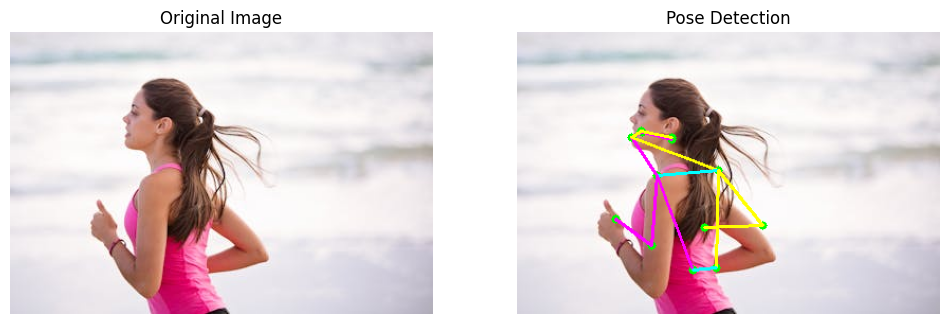

In [ ]:
# Run pose detection
keypoints = movenet_inference(image_rgb)
print(f"Keypoints shape: {keypoints.shape}")
print(f"Sample keypoint: {keypoints[0]}")

# Visualize results
output_image = draw_keypoints(image_rgb, keypoints)
output_image = draw_connections(output_image, keypoints, KEYPOINT_EDGE_INDS_TO_COLOR)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Pose Detection')
plt.axis('off')
plt.show()

In [ ]:
# Transfer learning example - create a simple activity classifier
def extract_features(keypoints):
    """Extract features from keypoints for classification."""
    # Simple features: relative positions of key joints
    features = []

    # Example features: hip-knee angle, shoulder-hip alignment, etc.
    left_hip = keypoints[11]
    right_hip = keypoints[12]
    left_knee = keypoints[13]
    right_knee = keypoints[14]
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]

    # Average hip position
    hip_y = (left_hip[0] + right_hip[0]) / 2
    hip_x = (left_hip[1] + right_hip[1]) / 2

    # Average knee position
    knee_y = (left_knee[0] + right_knee[0]) / 2
    knee_x = (left_knee[1] + right_knee[1]) / 2

    # Average shoulder position
    shoulder_y = (left_shoulder[0] + right_shoulder[0]) / 2
    shoulder_x = (left_shoulder[1] + right_shoulder[1]) / 2

    # Features
    features.extend([
        knee_y - hip_y,  # Vertical distance between knee and hip
        shoulder_y - hip_y,  # Vertical distance between shoulder and hip
        abs(left_knee[1] - right_knee[1]),  # Horizontal distance between knees
        abs(left_shoulder[1] - right_shoulder[1])  # Horizontal distance between shoulders
    ])

    return np.array(features)

In [ ]:
# Create a simple classifier (you would typically train this on more data)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
# Extract features from the current image as an example
current_features = extract_features(keypoints)
print(f"\nExtracted features: {current_features}")


Extracted features: [-0.04515636 -0.3389055   0.02972409  0.14441362]


In [ ]:
# Example: Create synthetic training data for demonstration
import random

In [ ]:
# Generate synthetic training data (just for demonstration)
training_data = []
labels = []

for i in range(50):
    # Simulate different poses with random variations
    synthetic_features = current_features + np.random.normal(0, 0.05, size=current_features.shape)

    # Assign labels based on feature patterns
    if synthetic_features[0] < -0.1:  # Knee well below hip
        label = 'sitting'
    elif abs(synthetic_features[2]) > 0.2:  # Knees far apart
        label = 'standing_wide'
    else:
        label = 'standing'

    training_data.append(synthetic_features)
    labels.append(label)

# Convert to numpy arrays
X_train = np.array(training_data)
y_train = np.array(labels)

# Create and train the classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_scaled, y_train)

# Predict on the current image
current_features_scaled = scaler.transform([current_features])
prediction = classifier.predict(current_features_scaled)[0]
prediction_proba = classifier.predict_proba(current_features_scaled)[0]

print(f"\nPredicted pose: {prediction}")
print("Prediction probabilities:")
for i, class_label in enumerate(classifier.classes_):
    print(f"  {class_label}: {prediction_proba[i]:.2f}")



Predicted pose: standing
Prediction probabilities:
  sitting: 0.01
  standing: 0.99
